In [1]:
from IPython.display import Math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

## Ignore this bit

Original file was 133 MB so I convert to HDF5 and compress...

In [3]:
import time
start = time.time()
 
data = np.loadtxt('data/F3_ss_dec_3x3')
 
end = time.time()
elapsed = end - start
print("Time taken to read volume: {:.2f} seconds.".format(elapsed))

Time taken to read volume: 12.92 seconds.


In [5]:
# Need to know:
nIL = 194  # number of inlines
nXL = 299  # number of crosslines
nt = 463   # number of samples per trace
dt = 0.004 # sample rate in seconds

volume = np.reshape(data, newshape = (nIL, nXL, nt))
print(volume.shape)

(194, 299, 463)


In [6]:
# Get rid of some bad data for the last few samples on each trace.
volume = volume[:,:,:451]
print(volume.shape)

(194, 299, 451)


Create initial dataset (orig data no longer in repo).

In [13]:
import h5py
h5f = h5py.File('data/seismic.h5', 'w')
h5f.create_dataset('data', data=volume, compression='lzf')
h5f.close()

## OK, start here

Load a pre-selected crossline from the volume

In [3]:
import h5py
h5f = h5py.File('data/seismic.h5','r')
volume = h5f['data'][:]
h5f.close()

In [4]:
XL = 50
line = volume[XL,:, : ]
print('crossline {} has {} traces and {} samples/trace.'.format(XL, line.shape[0], line.shape[1]))

crossline 50 has 299 traces and 451 samples/trace.


In [5]:
line.shape

(299, 451)

In [6]:
# Find the middle trace on this line
x = np.floor(line.shape[0]/2)
print('The middle trace on XL {} is in position {}.'.format(XL, x))

The middle trace on XL 50 is in position 149.0.


In [7]:
# Take the middle trace, 's' out of the array (at location x):
s = line[x]

print("the number of samples on this trace is: {}".format(len(s)))

# Find the max value along the trace.
biggest = np.amax(s)
print("Max value: {}".format(biggest))
print("located in element: {}".format(np.argmax(s)))

# Find the minimum value along the trace.
smallest = np.amin(s)
print("Min value: {}".format(smallest))
print("located in element: {}".format(np.argmin(s)))

# Find the peak to peak range of the trace.
amp_range = s.ptp()
print("Peak to peak: {}".format(amp_range))

# Check to see that the mean of the trace is close to zero.
print("Mean value: {:.2f}".format(np.mean(s)))

the number of samples on this trace is: 451
Max value: 11405.0
located in element: 447
Min value: -16408.0
located in element: 427
Peak to peak: 27813.0
Mean value: 9.86


FIGURE 1: plot the trace (vertically)

In [8]:
# Make a time axis.
t_min = 0.0
dt = 0.004
t_max = volume.shape[-1] * dt
t = np.arange(t_min, t_max, step=dt)
t[:20]

array([ 0.   ,  0.004,  0.008,  0.012,  0.016,  0.02 ,  0.024,  0.028,
        0.032,  0.036,  0.04 ,  0.044,  0.048,  0.052,  0.056,  0.06 ,
        0.064,  0.068,  0.072,  0.076])

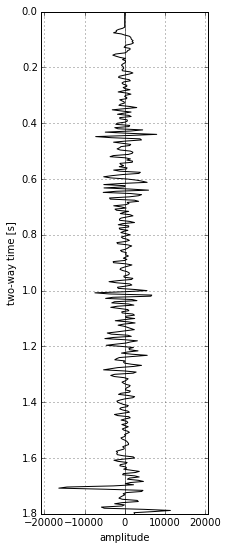

In [9]:
fig1 = plt.figure(figsize = (3,9), facecolor='white')
ax1 = fig1.add_subplot(111)
wigplt = ax1.plot(s, t,'k')

# plot the zero-crossing
vmin = -0.75*s.ptp()
vmax = 0.75*s.ptp()

zerocrossing = ax1.plot(np.zeros_like(s), t,'k', alpha=0.5)
ax1.set_xlim( (vmin, vmax) )
ax1.set_ylabel('two-way time [s]')
ax1.set_xlabel('amplitude')
ax1.invert_yaxis()
ax1.grid()

## Trace statistics

Let's look at a histogram of the values along this trace

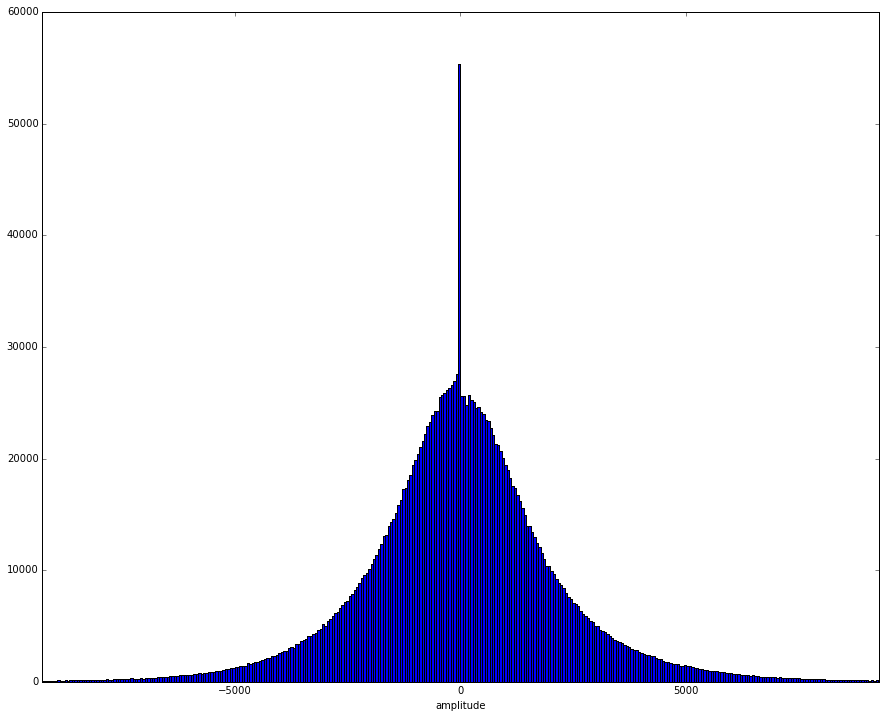

In [10]:
line = volume[50,...]
vmin = -0.2 * line.ptp()
vmax = 0.2 * line.ptp()

fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(111)

hist = ax.hist(np.ravel(volume[0:150:10,...]), bins=1000)

# centering the plot to the same x-range as above the plot
ax.set_xlim(vmin, vmax)
ax.set_xlabel('amplitude')

plt.show()

As suspected, most of the data values are close to zero, and fan outward (more or less symmetrically) to larger positive and negative values.

## Smart array encoding

[This is from SO.](http://stackoverflow.com/questions/3488934/simplejson-and-numpy-array/24375113#24375113) 

In [14]:
import base64
import json
import numpy as np

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        """
        If input object is a ndarray it will be converted into
        a dict holding dtype, shape and the data base64 encoded.
        """
        if isinstance(obj, np.ndarray):
            data_b64 = base64.b64encode(obj).decode('utf-8')
            return dict(
                        data=data_b64,
                        dtype=str(obj.dtype),
                        shape=obj.shape
                       )
        # Let the base class default method raise the TypeError
        return json.JSONEncoder(self, obj)


def ndarray_hook(dct):
    """
    Decodes a previously encoded numpy ndarray
    with proper shape and dtype.
    
    :param dct: (dict) json encoded ndarray
    :return: (ndarray) if input was an encoded ndarray
    """
    if isinstance(dct, dict) and 'data' in dct:
        data = base64.b64decode(dct['data'])
        return np.frombuffer(data, dct['dtype']).reshape(dct['shape'])
    return dct

expected = np.arange(100, dtype=np.float)
dumped = json.dumps(expected, cls=NumpyEncoder)
result = json.loads(dumped, object_hook=ndarray_hook)

assert result.dtype == expected.dtype, "Wrong Type"
assert result.shape == expected.shape, "Wrong Shape"
assert np.allclose(expected, result), "Wrong Values"

In [15]:
dumped

'{"shape": [100], "dtype": "float64", "data": "AAAAAAAAAAAAAAAAAADwPwAAAAAAAABAAAAAAAAACEAAAAAAAAAQQAAAAAAAABRAAAAAAAAAGEAAAAAAAAAcQAAAAAAAACBAAAAAAAAAIkAAAAAAAAAkQAAAAAAAACZAAAAAAAAAKEAAAAAAAAAqQAAAAAAAACxAAAAAAAAALkAAAAAAAAAwQAAAAAAAADFAAAAAAAAAMkAAAAAAAAAzQAAAAAAAADRAAAAAAAAANUAAAAAAAAA2QAAAAAAAADdAAAAAAAAAOEAAAAAAAAA5QAAAAAAAADpAAAAAAAAAO0AAAAAAAAA8QAAAAAAAAD1AAAAAAAAAPkAAAAAAAAA/QAAAAAAAAEBAAAAAAACAQEAAAAAAAABBQAAAAAAAgEFAAAAAAAAAQkAAAAAAAIBCQAAAAAAAAENAAAAAAACAQ0AAAAAAAABEQAAAAAAAgERAAAAAAAAARUAAAAAAAIBFQAAAAAAAAEZAAAAAAACARkAAAAAAAABHQAAAAAAAgEdAAAAAAAAASEAAAAAAAIBIQAAAAAAAAElAAAAAAACASUAAAAAAAABKQAAAAAAAgEpAAAAAAAAAS0AAAAAAAIBLQAAAAAAAAExAAAAAAACATEAAAAAAAABNQAAAAAAAgE1AAAAAAAAATkAAAAAAAIBOQAAAAAAAAE9AAAAAAACAT0AAAAAAAABQQAAAAAAAQFBAAAAAAACAUEAAAAAAAMBQQAAAAAAAAFFAAAAAAABAUUAAAAAAAIBRQAAAAAAAwFFAAAAAAAAAUkAAAAAAAEBSQAAAAAAAgFJAAAAAAADAUkAAAAAAAABTQAAAAAAAQFNAAAAAAACAU0AAAAAAAMBTQAAAAAAAAFRAAAAAAABAVEAAAAAAAIBUQAAAAAAAwFRAAAAAAAAAVUAAAAAAAEBVQAAAAAAAgFVAAAAAAADAVUAAAAAAAABWQAAAA

## To JSON

In [17]:
# Making UUIDs
import uuid
uuid.uuid1()

UUID('99d56106-41e7-11e5-b29e-c4850892820e')

In [18]:
# Data percentiles
perc = {}
for p in [1, 5, 50, 95, 99]:
    perc[p] = np.percentile(line, p)
perc

{1: -6399.5200000000004,
 5: -3546.5999999999995,
 50: 0.0,
 95: 3538.0,
 99: 6270.5599999999686}

In [20]:
# Global min and max
np.amin(volume), np.amax(volume)

(-29579.0, 30439.0)

Target JSON pseudocode:

In [ ]:
{
    'name': 'F3',
    'location': 'Netherlands',
    'uuid': 'b4a7b5a8-41c2-11e5-85a7-c4850892820e',
    'polarity': 'normal',  # Ambiguous: down incr = peak
    'company': 'unknown',
    'source': 'airgun',
    'receiver': 'hydrophone',
    'type': 'marine',  # land, borehole, etc.
    'header': 'arbitrary string of stuff or EDCDIC header',

    'data': [
        [ 'first trace' ],
        [ 'second trace' ],
        '...',
    ],

    'metadata': {
        'dim': 2,
        'shape': [299, 451],
        'dtype': int,
        'min': -16408,
        'max': 11405,
        'perc': perc,
        'global_min': -29579.0,
        'global_max': 30439.0,
    },
    
    'z': {
        'min': 0,
        'max': 1.800,
        'int': 0.004,
        'units': 's',
        'domain': 'time',
    },
            
    'geometry': {
        'parent': '3D',
        'type': '2D',  # Can infer this from data shape
        'cdpmin': 0,
        'cdpmax': 298,
        'corners': [[50000, 15000], [7000, 17000]],
        'crs': 'EPSG:4326',
        'units': 'm',
    },
}

OK, now make the real thing, but in a roundabout way... This should be a method on some sort of seismic object. 

In [25]:
dictionary = {'metadata': {},
              'geometry': {},
              'z': {},
              }

In [26]:
dictionary['name'] = 'F3'
dictionary['location'] = 'NEtherlands'
dictionary['polarity'] = 'normal'
dictionary['company'] = 'unknown'
dictionary['type'] = 'marine'
dictionary['airgun'] = 'airgun'
dictionary['uuid'] = str(uuid.uuid1())

dictionary['metadata']['dim'] = line.ndim
dictionary['metadata']['shape'] = list(line.shape)
dictionary['metadata']['min'] = -16408
dictionary['metadata']['max'] = 11405
dictionary['metadata']['perc'] = perc
dictionary['metadata']['global_min'] = -29579.0
dictionary['metadata']['global_max'] = 30439.0

dictionary['z']['min'] = 0
dictionary['z']['max'] = 1.800
dictionary['z']['int'] = 0.004
dictionary['z']['units'] = 's'
dictionary['z']['domain'] = 'time'

dictionary['geometry']['cdpmin'] = 0
dictionary['geometry']['cdpmax'] = 298


In [27]:
dictionary

{'airgun': 'airgun',
 'company': 'unknown',
 'geometry': {'cdpmax': 298, 'cdpmin': 0},
 'location': 'NEtherlands',
 'metadata': {'dim': 2,
  'global_max': 30439.0,
  'global_min': -29579.0,
  'max': 11405,
  'min': -16408,
  'perc': {1: -6399.5200000000004,
   5: -3546.5999999999995,
   50: 0.0,
   95: 3538.0,
   99: 6270.5599999999686},
  'shape': [299, 451]},
 'name': 'F3',
 'polarity': 'normal',
 'type': 'marine',
 'uuid': 'da6c3c1c-41e7-11e5-b29e-c4850892820e',
 'z': {'domain': 'time', 'int': 0.004, 'max': 1.8, 'min': 0, 'units': 's'}}

In [28]:
json.dumps(dictionary)

'{"z": {"domain": "time", "int": 0.004, "min": 0, "max": 1.8, "units": "s"}, "location": "NEtherlands", "polarity": "normal", "uuid": "da6c3c1c-41e7-11e5-b29e-c4850892820e", "airgun": "airgun", "metadata": {"shape": [299, 451], "min": -16408, "dim": 2, "perc": {"1": -6399.52, "50": 0.0, "99": 6270.559999999969, "5": -3546.5999999999995, "95": 3538.0}, "max": 11405, "global_max": 30439.0, "global_min": -29579.0}, "geometry": {"cdpmin": 0, "cdpmax": 298}, "name": "F3", "company": "unknown", "type": "marine"}'

Check to see how big the list is as a string...

In [29]:
snp = json.dumps(line.tolist())
len(snp)

1073473

...and as a base64 encoded string...

In [30]:
l = line.copy(order='C')
s64 = json.dumps(l, cls=NumpyEncoder)
len(s64)

1438445

(Aside: maybe we can compress, or reduce bitdepth?)

OK, just stick to string...

In [31]:
dictionary['data'] = line.tolist()

In [32]:
import json
with open('/home/matt/Dropbox/Public/seismic.json', 'w') as f:
    f.write(json.dumps(dictionary))